# Multiple Hypothesis t-Test and Bonferroni Correction 

**Summary**: This notebook illustrates a multiple hypothesis testing, familywise error rates and the application of Bonferroni correction.

In [2]:
# imports 
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.stats import t
import stat_tests
from sim_data import get_sim_data

# I. Simulating a Dataset from Random Samples

In [3]:
#Import Simulated Data (Will take a while to run)
data = get_sim_data()

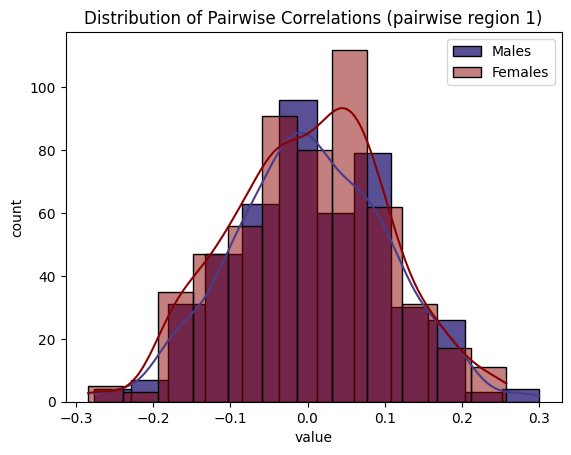

In [31]:
# param = 1.0
separable_data = data[-1]
separable_data_m = np.stack(separable_data.loc[separable_data.gender == 'M']['corr'].values)
separable_data_f = np.stack(separable_data.loc[separable_data.gender == 'F']['corr'].values)

# population 1
n1 = 550 # arbitrary sample size
# population 2
n2 = 450 # arbitrary sample size

num_region = 100
num_correlation = 4950
m_netmats = np.zeros((num_correlation, n1))
f_netmats = np.zeros((num_correlation, n2))
# generate two sets of simulated pairwise correlations from a normal distribution with the respective parameters
n = 0
upper_left_indices = np.triu_indices(num_region, k=1)
for i, j in zip(*upper_left_indices):
    # get random pairwise reigon
    m_netmats[n] = np.random.choice(separable_data_m[:, i, j], n1)
    f_netmats[n] = np.random.choice(separable_data_f[:, i, j], n2)
    n += 1

# get distribution of pairwise correlation at i=0
pairwise_region = 0
m_corr = m_netmats[pairwise_region]
f_corr = f_netmats[pairwise_region]

# plot the two samples
bins = 12
ax = sns.histplot(f_corr, kde=True, bins=bins, label="Males", alpha=0.9, color="darkslateblue")
ax = sns.histplot(m_corr, kde=True, bins=bins, label="Females", alpha=0.5, color="darkred")
ax.set(xlabel='value', ylabel='count', title=f'Distribution of Pairwise Correlations [$b=1.0$] for ${(i, j)}$')
plt.legend()
plt.show()

# II. Calculating the $t$-Statistics and p-values

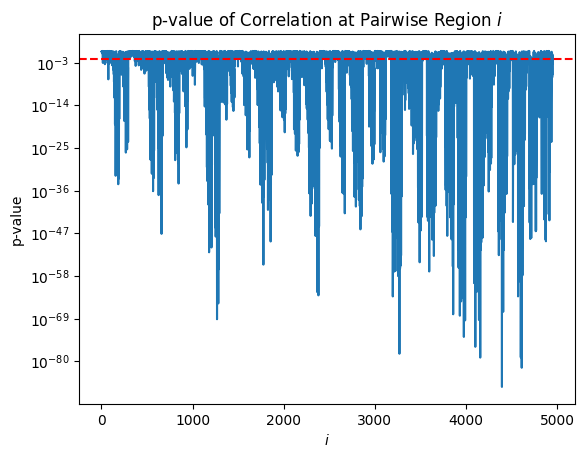

In [45]:
alpha = 0.01

# calculate the t-statistic and p-values for each pairwise correlation value 
t_stats, mf_sqse, pvals = stat_tests.get_tstats(f_netmats.T, m_netmats.T)

# plot p-values
plt.plot(pvals)
plt.axhline(y=alpha, color='r', linestyle='--')

plt.title('p-value of Correlation at Pairwise Region $i$')
plt.xlabel('$i$')
plt.ylabel('p-value')
plt.yscale('log')

As we can see, the t-test yielded a p-value < $\alpha$ for all of the pairwise correlations. This is because of the separability of the male and female population distributions. 

However, when working with a real-life dataset, the distributions may be less distinct. We can repeat this simulation, but with two distributions that have the same population mean to demonstrate the $t$-tests' performances on distributions with less distinct means.

## III. Checking Error Rate

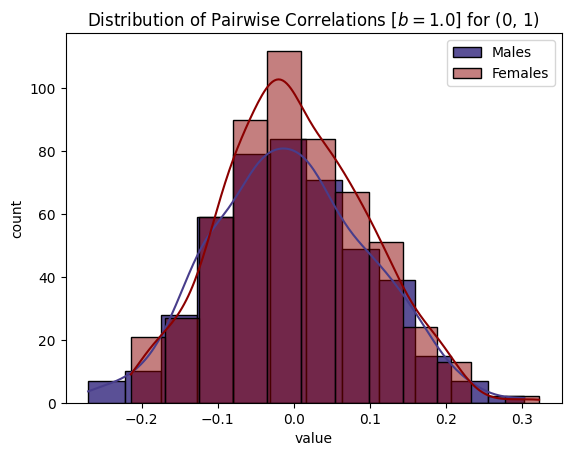

In [99]:
# param = 0
separable_data_null = data[0]
separable_data_m_null = np.stack(separable_data_null.loc[separable_data_null.gender == 'M']['corr'].values)
separable_data_f_null = np.stack(separable_data_null.loc[separable_data_null.gender == 'F']['corr'].values)

# population 1
n1 = 550 # arbitrary sample size
# population 2
n2 = 450 # arbitrary sample size

num_region = 100
num_correlation = 4950
m_netmats_null = np.zeros((num_correlation, n1))
f_netmats_null = np.zeros((num_correlation, n2))
# generate two sets of simulated pairwise correlations from a normal distribution with the respective parameters
n = 0
upper_left_indices = np.triu_indices(num_region, k=1)
for i, j in zip(*upper_left_indices):
    # get random pairwise reigon
    m_netmats_null[n] = np.random.choice(separable_data_m_null[:, i, j], n1)
    f_netmats_null[n] = np.random.choice(separable_data_f_null[:, i, j], n2)
    n += 1

# get distribution of pairwise correlation at i=0
pairwise_region = 0
m_corr_null = m_netmats_null[pairwise_region]
f_corr_null = f_netmats_null[pairwise_region]

# plot the two samples
bins = 12
ax = sns.histplot(f_corr_null, kde=True, bins=bins, label="Males", alpha=0.9, color="darkslateblue")
ax = sns.histplot(m_corr_null, kde=True, bins=bins, label="Females", alpha=0.5, color="darkred")
ax.set(xlabel='value', ylabel='count', title=f'Distribution of Pairwise Correlations [$b=1.0$] for (0, 1)')
plt.legend()
plt.show()

C:\Users\Jense\AppData\Local\Temp\ipykernel_17544\2231087176.py:19: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, alpha+0.01)


(1.070913198392506e-09, 0.02)

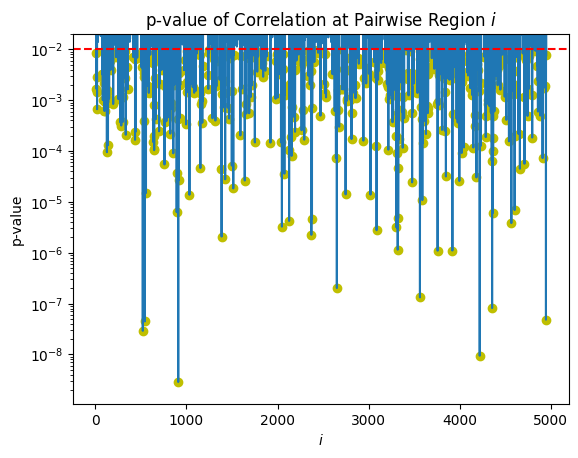

In [101]:
# calculate the t-statistic and p-values for each pairwise correlation value 
_, _, null_pvals = stat_tests.get_tstats(m_netmats_null.T, f_netmats_null.T)

# plot p-values
plt.plot(null_pvals)
plt.axhline(y=alpha, color='r', linestyle='--')

plt.title('p-value of Correlation at Pairwise Region $i$')
plt.xlabel('$i$')
plt.ylabel('p-value')
plt.yscale('log')


# highlight p-vals less than alpha
fp_ix = np.where(null_pvals < alpha)
fp = null_pvals[fp_ix]
plt.scatter(x=fp_ix, y=fp, color='y')

plt.ylim(0, alpha+0.01)

When comparing the difference of means for 4950 simulated pairwise correlations that are sampled from a the same normal distribution, we see that their respective $t$-statistics yield p-values less than $\alpha$. In other words, the two-sided independent samples $t$-test yields false positives.

In [76]:
print(f"The two-sided independent samples t-test (alpha={alpha}) yielded {len(fp)} false positives (rate={len(fp) / num_correlation})).")

The two-sided independent samples t-test (alpha=0.01) yielded 429 false positives (rate=0.08666666666666667)).


The false positive rate is approximately equal to $\alpha=0.01$, as expected. However, for our exploratory data analysis, we are interested in conducting a more conservative statistical test.

# IV. Applying Bonferroni Correction

When performing a statistical test, the significance level ($\alpha$) is defined as the probability of incorrectly rejecting the null hypothesis. The significance level can be interpreted as the amount of evidence we must observe in order to reject the null hypothesis and declare statistically significant results.  

When considering multiple hypothesis testing, the probability of incorrectly rejecting the null hypothesis, also referred to as false positive rate, is equal to $\alpha$ for *each* hypothesis. The *total* false positive rate, however, is also dependent on $n$, or the number of hypotheses:

$$
P_{FWER} = 1 - (1 - \alpha)^n
$$

This is recognized as the Familywise Error Rate ($FWER$), or the probability of at least one false positive. Using this formula, our multiple hypotheses test has a probability of incorrectly rejecting the null hypothesis once ($FWER$) of almost 1. The Bonferroni correction is a correction that change the $\alpha$ to reduce the Family Wise Error rate.  

Bonferroni-corrected $\alpha$:
$$
\frac{\alpha}{n}
$$ 

Plugging in the Bonferroni-corrected $\alpha$ into the Familywise Error Rate equation, assuming that $n$ is large and $\alpha$ is small, our new total probability of incorrecting the null hypothesis is approximately equal to $\alpha$:

$$
P_{FWER} = 1 - (1 - \frac{\alpha}{n})^n \\
\approx \alpha
$$

We can apply this Bonferroni correction to the alpha for our simulated-data $t$-test:

C:\Users\Jense\AppData\Local\Temp\ipykernel_17544\4039062420.py:18: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, bonferroni_alpha+0.01)


(2.238518840754838e-10, 0.010002020202020203)

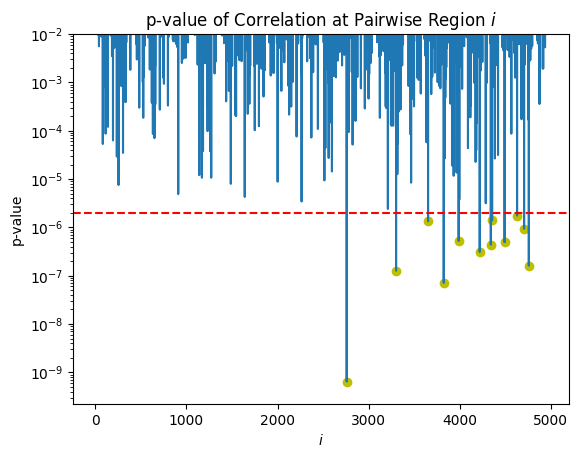

In [77]:
bonferroni_alpha = alpha / num_correlation # Bonferroni correction

# plot p-values
plt.plot(null_pvals)
plt.title('p-value of Correlation at Pairwise Region $i$')
plt.xlabel('$i$')
plt.ylabel('p-value')
plt.yscale('log')

# highlight p-vals less than alpha
plt.axhline(y=bonferroni_alpha, color='r', linestyle='--')
bonferroni_fp_ix = np.where(null_pvals < bonferroni_alpha)[0]
bonferroni_fp = null_pvals[bonferroni_fp_ix]

plt.scatter(x=bonferroni_fp_ix, y=bonferroni_fp, color='y')


plt.ylim(0, bonferroni_alpha+0.01)

In [98]:
print(f"As we can see, our new total false positive rate is much lower, yielding a new false positive rate of {bonferroni_fp_ix.shape[0] / null_pvals.shape[0]} (approximately alpha_bonferroni = {np.round(bonferroni_alpha, 2)}.")

As we can see, our new total false positive rate is much lower, yielding a new false positive rate of 0.0024242424242424242 (approximately alpha_bonferroni = 0.0.
